In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
def dct_basis(n,k1,k2):
    x = np.array([range(n)])
    x = 2*np.cos(np.pi*(2*x+1)*k1/2.0/n)
    red1 = 1/np.sqrt(2) if k1==0 else 1

    y = np.array([range(n)])
    y = 2*np.cos(np.pi*(2*y+1)*k2/2.0/n)
    red2 = 1/np.sqrt(2) if k2==0 else 1
    
    return np.dot(x.T,y)*red1*red2/2/n

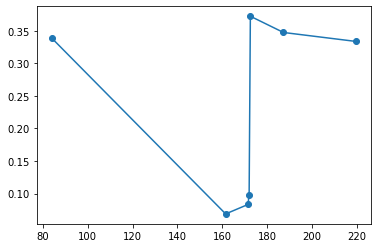

In [3]:
class DCT_CONV(nn.Module):
    def __init__(self, ksize=8, T=36):
        ''' k: kernel size
            T: number of first coefficients used'''
        super(__class__, self).__init__()

        dtype = torch.FloatTensor
        if torch.cuda.is_available():  dtype = torch.cuda.FloatTensor
        self.ksize=ksize
        ch = ksize**2

        self.T = T

        self.padding = nn.ReflectionPad2d(2*ksize//2-1)

        self.conv_in = nn.Conv2d(in_channels=1, out_channels= ch,
                                    kernel_size=ksize, stride=1,
                                    padding=0, bias=False)

        indices = [(i%ksize,i//ksize) for i in range(ch)]
        indices.sort(key=lambda e: e[0]+e[1])
        for ind,i in zip(indices,range(ch)):         
            a1 = dct_basis(ksize,ind[0],ind[1])
            self.conv_in.weight.data[i,0,:,:] = nn.Parameter(dtype(a1))

    def forward(self, x):
        out = self.conv_in(self.padding(x[None,None,:]))
        return out[0]

    def mean_dct(self, output):
        '''mean of the output'''
        return output[0, :, :]/self.ksize

    def lowfreq_var(self,output):
        '''low_frequency variance'''
        low_freq = output[1:self.T, :, :]**2 # exclude mean
        low_freq = torch.sum(low_freq,dim=0)/(self.T-1)
        return low_freq

    def noise_var(self, output, mean_dct, lowfreq_var, low_val, high_val, f_var=0.01):
        '''returns relevant noise variance when image value is between low_val and high_val
            f_var: fractions used to estimate noise'''
        # select image values between low_val and high_val
        mean_mask = (mean_dct<high_val)*(mean_dct>=low_val) 

        # Select small low_frequency variances (~uniform patches)
        lowf_variances = torch.masked_select(lowfreq_var, mean_mask) 
        if lowf_variances.size()[0]==0:
            return torch.tensor([]),torch.tensor([])
        tresh = torch.quantile(lowf_variances,f_var)
        lowf_mask = (lowfreq_var<tresh)*mean_mask

        # mask the corresponding pixels
        high_freq = (output[self.T:]*lowf_mask)**2
        high_freq = torch.sum(high_freq, dim=(1,2))/torch.sum(lowf_mask) # mean of the variances [ksize**2 - T] vector
        return torch.median(high_freq)

    def image_variance_hist(self, x, e_per_bin=40000, f_var=0.01):
        ''' input: [H,W] tensor
            output: variance histogram'''

        # compute DCT transforms, dim [ksize**2, H, W]
        output = self.forward(x)

        # compute image mean values 
        mean_dct = self.mean_dct(output) # dim [H, W]
        mean_list = mean_dct.flatten().sort()[0]

        # compute lowfreq_var
        lowfreq_var = self.lowfreq_var(output) # dim [H, W]

        Lmeans=[]
        Lvars=[]
        for index in range(0, len(mean_list), e_per_bin):
            low_val = mean_list[index]
            high_val = mean_list[min(index+e_per_bin,len(mean_list)-1)]
            Lmeans.append( (high_val+low_val).item()/2)
            Lvars.append(self.noise_var(output,mean_dct, lowfreq_var,low_val,high_val, f_var).item())
        return Lmeans,Lvars
        

    def show_net(self):
        out_img = np.zeros((self.ksize**2,self.ksize**2))
        for i in range(self.ksize**2):
            x = i//self.ksize
            y = i%self.ksize
            out_img[x*self.ksize:(x+1)*self.ksize,y*self.ksize:(y+1)*self.ksize]=self.conv_in.weight.data[i,0,:,:] 
        plt.imshow(out_img)
        plt.show()

%matplotlib inline

M = DCT_CONV(ksize=8)
# M.show_net()
im = np.array(Image.open("forged_images/cyg.png"))
im = np.array(im).mean(axis=2) # convert to bw
im = torch.FloatTensor(im)

Lm,Lv= M.image_variance_hist(im, e_per_bin=40000, f_var=0.005)
plt.plot(Lm,Lv,'o-')


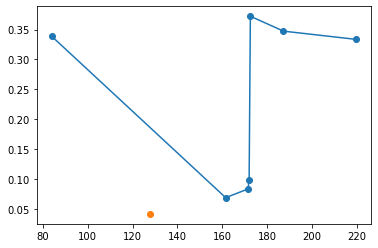

In [4]:
Lm,Lv= M.image_variance_hist(im, e_per_bin=40000, f_var=0.005)
plt.plot(Lm,Lv,'o-')
Lm2,Lv2= M.image_variance_hist(im[100:180,120:190], e_per_bin=20000, f_var=0.005)
plt.plot(Lm2,Lv2,'o-')